In [1]:
%reload_ext autoreload
%autoreload 2

import msprime 

In [2]:
from tslearn.imports import *
from tslearn.helpers import *
from tslearn.networks import *
from tslearn.simulator import *
from tslearn.treesBatchGenerator import *


In [3]:
# make directory tree
cwd = os.getcwd()
sets = ["train","vali","test"]
for subset in ("trees","results"):
    subDir = os.path.join(cwd, subset)
    if not os.path.exists(subDir):
        os.mkdir(subDir)
treeDir = os.path.join(cwd,"trees")
for subset in sets:
    subDir = os.path.join(treeDir,subset)
    if not os.path.exists(subDir):
        os.mkdir(subDir)

In [4]:
# assign simulation parameters
numReps = [int(1e4), int(1e3), int(1e3)]
mrPrior = [1e-8, 1e-8]
rrPrior = [1e-9, 1e-9]
sPrior = [1e-1, 1e-1]

sample_size = 10
nProc=mp.cpu_count()

dg_params = {
    'seed':1234,
    'N':sample_size,
    'Ne':1e4,
    'mrPrior':mrPrior,
    'rrPrior':rrPrior,
    'chromLength':1e6,
    's':sPrior,
    'ReLERNN':False
          }
    
# simulate and produce trees
max_table_size = np.zeros(5) #[max_nodes, max_edges, max_sites, max_mutations, max_trees]
for i, subset in enumerate(sets):
    data_generator = SimulatorSweep(**dg_params)
    direc = os.path.join(treeDir,subset)
    table_lens = data_generator.simulateAndProduceTrees(numReps=numReps[i],
            direc=direc,simulator="msprime",nProc=nProc)
    if subset != "test":
        max_table_size = np.maximum(max_table_size, table_lens)
    

Simulate...
Simulate...
Simulate...


In [5]:
# initialize universal batch generator params
train_batch_params = {
    'targetNormalization':'binary',
    'batchSize': 64,
    'frameWidth': 0,
    'center':True,
    'shuffleExamples':True,
    'maxTsTableSize':max_table_size,
    'ReLERNN':False
          }
vali_batch_params = copy.deepcopy(train_batch_params)
test_batch_params = copy.deepcopy(train_batch_params)

# define set-specific parameters
targets = [
        "sel_coefs",
        ]

params = [train_batch_params, vali_batch_params, test_batch_params]
for i, subset in enumerate(sets):
    # universal params    
    params[i]['treesDirectory'] = os.path.join(treeDir,subset)
    params[i]['numReps'] = numReps[i]
    info = pickle.load(open(os.path.join(os.path.join(treeDir, subset),"info.p"), "rb"))
    params[i]['rawTargets'] = [info[target] for target in targets]

    # test specific params
    if subset == "test":
        params[i]['batchSize'] = numReps[i]
        params[i]['shuffleExamples'] = False

    #False write batch parameters
    batchParsFILE=os.path.join(treeDir,"{}_batch_params.p".format(subset))
    with open(batchParsFILE, "wb") as fOUT:
        pickle.dump(params[i],fOUT)

## initialize batch generators
train_batch_gen = treesBatchGenerator(**train_batch_params)
vali_batch_gen = treesBatchGenerator(**vali_batch_params)
test_batch_gen = treesBatchGenerator(**test_batch_params)

In [56]:
##########################TRAIN##########################
## define model files
modelFile = os.path.join(cwd,"results","model.json")
weightsFile = os.path.join(cwd,"results","weights.h5")
resultsFile = os.path.join(cwd,"results","model.results")
resultsFig = os.path.join(cwd,"results","results.pdf")

netArchs = {
        "ReLERNN" : RELERNN,
        "LSTM4C_class" : LSTM4C_class,
        "DENSE4_class" : DENSE4_class,
        "CNN2D" : CNN2D,
        }

history = train_model(ModelFuncPointer=netArchs["CNN2D"],
        ModelName="CNN2D",
        targetLabels=targets,
        TrainGenerator=train_batch_gen,
        ValidationGenerator=vali_batch_gen,
        TestGenerator=test_batch_gen,
        numEpochs=20,
        resultsFile=resultsFile,
        network=[modelFile,weightsFile],
        nProc=1,
        gpuID=2)

TypeError: 'float' object is not subscriptable

In [57]:
b = train_batch_gen._treesBatchGenerator__data_generation([0, 1, 2])
b[0][0]

TypeError: 'float' object is not subscriptable

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'predictions', 'Y_test', 'name', 'target_labels'])


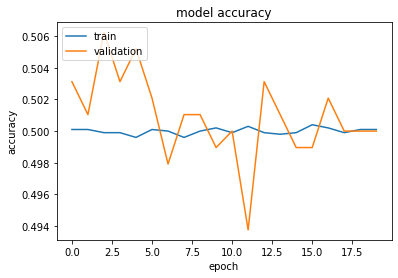

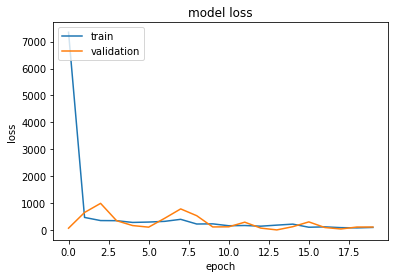

In [36]:
print(history.history.keys())
#  "Accuracy"
%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [29]:
import pickle
import tskit


In [64]:
info = pickle.load(open("trees/test/info.p", "rb"))
pis = []
for i in range(len(info['sel_coefs'])):
    ts = tskit.load(f"trees/test/{i}.trees")
    pis.append(ts.diversity(mode='branch'))
pis = np.array(pis)
print(pis[:500].mean(),
    pis[500:].mean()
     )

2.320305964932469 3.8860880188001885


<AxesSubplot:xlabel='label', ylabel='pi'>

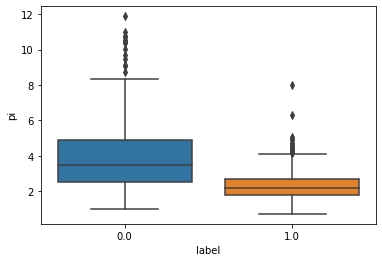

In [65]:
%matplotlib inline
import pandas as pd
import seaborn as sns

fac = pd.DataFrame({'pi':pis, 'label':np.ones(len(pis))})
fac.label[500:] -= 1
sns.boxplot(x='label', y='pi', data=fac)

In [23]:
info.keys()

dict_keys(['seed', 'N', 'Ne', 'mrPrior', 'rrPrior', 'chromLength', 's', 'ReLERNN', 'numReps', 'rho', 'mu', 'sel_coefs', 'numNodes', 'numEdges', 'numSites', 'numMutations', 'numTrees'])